In [1]:
%load_ext autoreload
%autoreload 2

import li.analysis as la
import li.visualize as vi
import li.EvaluationHelpers as eh
import li.diagnostic as diagnostic

import os
import seaborn
import numpy as np
import pandas as pd
from PIL import Image # for reading images
import scipy.constants as const
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams

rcParams['font.family'] = 'Helvetica'

# Data Loading and Definition of Variables

In [2]:
# date = "20250306"
# images_set = "D-effMass_810G_Bragg"

# date = "20250219"
# images_set = "F-balance_heated_Spectrum"

# adiabatic ramping of B field
# date = "20250324"
# images_set = "C-Adiabatic_temperature_ramp_T4_25ms"

# T4 imaging at different fields
# date = "20250325"
# images_set = "A-Temperature_FB_Img_scan_wide_range"

# T4 imaging at different Ring hold times
# date = "20250325"
# images_set = "B-Temperature_High_Ring_Hold"

# T4 imaging at different fields with high statistics
date = "20250327"
images_set = "A-Temperature_FB_Img_high_stat"


path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

# ref_set = "D-effMass_810G_zeroResp"
# ref_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + ref_set + "/"
# ref_file = os.listdir(ref_dir)

print(len(path_file))
print(path_file[-1])

14980
BrightDarkM_i_965_FB_Img_750.png


In [3]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

# ref_variables = la.loop_variables(ref_dir + ref_file[0])[1]
# ref_var_vals = la.loop_variables(ref_dir + ref_file[0])[0]

print(f"{images_set}")
for i, var in enumerate(variables):
    print(f"{var}: {var_vals[i][0]} - {var_vals[i][-1]}")

print("")

# print(f"{ref_set}")
# for i, var in enumerate(ref_variables):
#     print(f"{var}: {ref_var_vals[i][0]} - {ref_var_vals[i][-1]}")

A-Temperature_FB_Img_high_stat
i: 1.0 - 1000.0
FB_Img: 720.0 - 780.0



In [4]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [5]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 62.5 ms
Wall time: 1.73 s


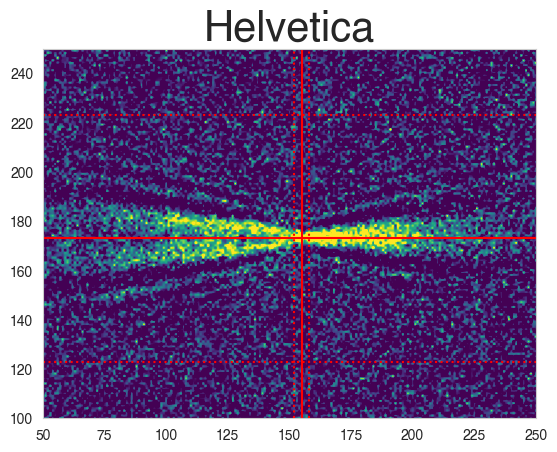

In [6]:
# determine optimal ROI
center = (173, 155)
h = 50
w = 3

# rcParams['font.family'] = 'Helvetica'

single_prc = la.density_builder([images_raw[0]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.title("Helvetica", fontsize = 30)

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")

plt.grid(False)

plt.show()

In [7]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 2996/2996 [100%] in 13:07.6 (3.80/s) 
CPU times: total: 5min 6s
Wall time: 13min 7s


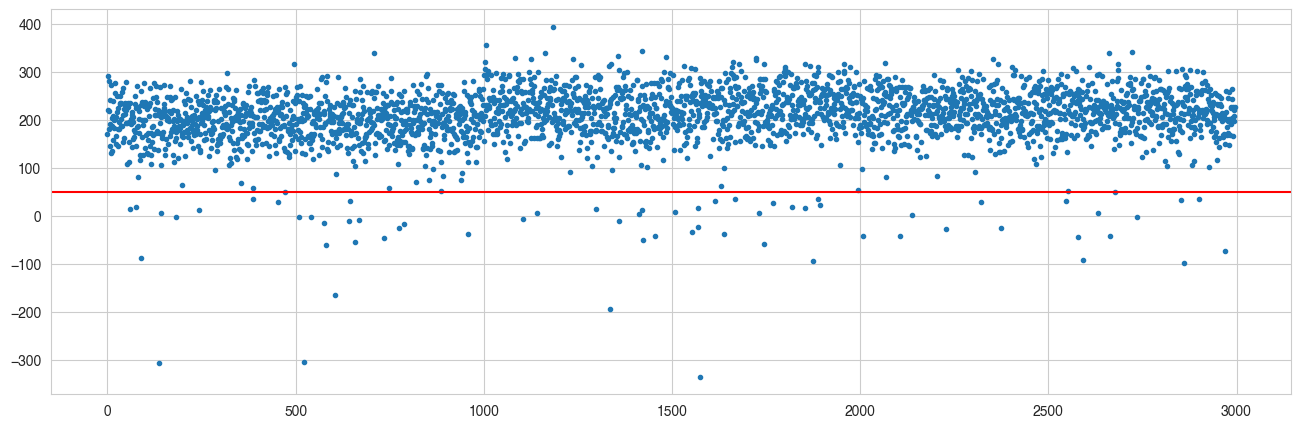

2996


In [8]:
# filter out missed shots
bol = []

for val in var_vals[1]:
    # for val2 in var_vals[2]:

    mask = (np.isclose(images_prc["FB_Img"], val)) #  &
            # np.isclose(images_prc["Acc_heat_freq"], val2))

    for i, im in images_prc[mask].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(50, c = "r")

plt.ylim(None, None)

plt.show()

print(len(bol))

In [9]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 50)

CPU times: total: 812 ms
Wall time: 994 ms


In [10]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])

MULTI MODE
CPU times: total: 1min 51s
Wall time: 3min 5s


In [11]:
# constants

omega_T4 = 2 * const.pi * 27.3 # angular frequency of T4 harmonic [Hz]
m_Li = 9.9883414e-27           # mass of lithium [kg]
px_to_x = 1.09739368998628e-6  # effective pixel size in [m]

wl_laser = 671e-9  # resonant wavelength for imaging
sigma_factor = 1
sigma_zero = 3 * (wl_laser ** 2) / (2 * np.pi)
sigma_eff = sigma_factor * sigma_zero

A = px_to_x**2  # pixel size in m**2
gain = 1

def T4_fit(images, lim_left, lim_right):
    """
    Function:
        This function determines the T4 peaks of the densities using fitting and running average methods.
        The densities in the region of interest are averaged along the beatle to yield an averaged density profile.
        The peaks are determined using both a gauss + parabola fit as well as a double running average.

    Arguments:
        images -- {pandas dataframe} averaged densities for all combinations of loop variables

    Returns:
        {pandas dataframe} additionally containing fit parameters and T4 peaks
    """

    images_fit = images.copy()

    # add new columns
    T4_params = []
    T4_peak = []
    # T4_run_peak = []
    temperature = []

    for i, im in images_fit.iterrows():

        # calculate averaged density profile
        T4 = np.mean(im["density"], axis = 1).compressed()
        pos = np.arange(0, len(T4))

        mask = (pos >= lim_left) & (pos < lim_right)

        # peak from gauss + parabola fit
        popt, pcov = curve_fit(la.gauss, pos[~mask], T4[~mask], p0 = [0.5, 50, 700], bounds=([0, 40, 0], [1, 60, 1000]))

        T4_params.append(popt)
        T4_peak.append(popt[0])

        # peak from double running average
        # T4_run_peak.append(np.max(running_average(T4, 5)))

        # calculate temperature
        T = popt[2] * px_to_x**2 * m_Li * omega_T4**2 / const.k * 1e9
        T_err = px_to_x**2 * m_Li * omega_T4**2 / const.k * 1e9 * np.sqrt(np.diag(pcov)[2])
        temperature.append([T, T_err])

    images_fit["T4_params"] = T4_params
    images_fit["T4_peak"] = T4_peak
    # images_fit["T4_run_peak"] = T4_run_peak
    images_fit["temperature"] = temperature

    return images_fit

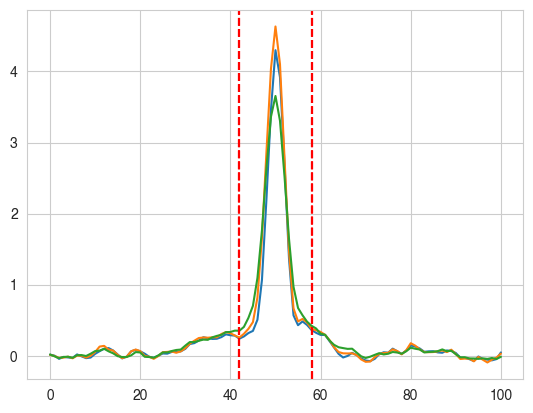

In [12]:
for i, im in images_grp.iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))

    plt.plot(pos, T4)

    plt.axvline(42, color = "red", ls = "--")
    plt.axvline(58, color = "red", ls = "--")

plt.show()

In [27]:
%%time
# make T4 fits
images_fit = T4_fit(images_grp, 42, 59)

CPU times: total: 0 ns
Wall time: 19.1 ms


In [14]:
# %%time
# ref_raw = eh.createImageInfoList([ref_dir], ref_variables)
# # print("RAW DONE")
# ref_prc = la.density_builder(ref_raw, ref_variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)
# # print("DENSITY DONE")
# ref_fil = la.filter(ref_prc, 80)
# # print("FILTER DONE")
# ref_grp = la.group(ref_fil, ref_variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])
# # print("GROUP DONE")
# ref_fit = la.T4_fit(ref_grp)
# # print("FIT DONE")

In [22]:
%%time
# calculate response
images_res = la.response(images_grp, images_grp, 750, index = None, column = "FB_Img")

CPU times: total: 0 ns
Wall time: 999 μs


# Visualization

In [67]:
def spectrum(images, index, columns, values, ticknum_x = 1, ticknum_y = 1, decimal_x = "float2", decimal_y = "float2", rescale_x = 1, rescale_y = 1, rotation_x = 0, title = "INSERT TITLE HERE", xlabel = "X LABEL", ylabel = "Y LABEL", vmin = 0, vmax = 1, cmap = "viridis"):
    """
    Function:
        This function visualizes the response as a function of all loop variables in a heatmap.

    Arguments:
        images  -- {pandas dataframe, containing respsonse from T4 peaks
        index   -- {string} loop variable on y-axis
        columns -- {string} loop variable on x-axis
        values  -- {string} heatmap values (usually response)
        title   -- {string} title of the heatmap
        vmin    -- {scalar} lower bound of colormap
        vmax    -- {scalar} upper bound of colormap
        cmap    -- {string} colormap name

    Returns:
        {matplotlib axis} heatmap of response
    """

    # turn dataframe into heatmap shape
    heat = images.pivot(index = index, columns = columns, values = values)

    # true values (3.5, 2.5)
    # plt.figure(figsize = (3.5, 2.5), edgecolor = "black")

    ax = plt.axes()

    # plot heatmap
    seaborn.heatmap(heat, ax = ax, vmin = vmin, vmax = vmax, cmap = cmap).invert_yaxis()

    ax.set_title(f"{title}", pad = 13, fontsize = 20)
    ax.set_xlabel(f"{xlabel}", fontsize = 7)
    ax.set_ylabel(f"{ylabel}", fontsize = 7)

    # x ticks
    x_ticks = np.arange(0.5, len(heat.columns) + 0.5)[0::ticknum_x]
    x_int = [f"{x/rescale_x:.0f}" for x in heat.columns[0::ticknum_x]]
    x_float1 = [f"{x/rescale_x:.1f}" for x in heat.columns[0::ticknum_x]]
    x_float2 = [f"{x/rescale_x:.2f}" for x in heat.columns[0::ticknum_x]]

    if decimal_x == "int":
        ax.set_xticks(x_ticks, x_int, rotation = rotation_x, fontsize = 7)
    elif decimal_x == "float1":
        ax.set_xticks(x_ticks, x_float1, rotation = rotation_x, fontsize = 7)
    elif decimal_x == "float2":
        ax.set_xticks(x_ticks, x_float2, rotation = rotation_x, fontsize = 7)

    # y ticks
    y_ticks = np.arange(0.5, len(heat.index) + 0.5)[0::ticknum_y]
    y_int = [f"{y/rescale_y:.0f}" for y in heat.index[0::ticknum_y]]
    y_float1 = [f"{y/rescale_y:.1f}" for y in heat.index[0::ticknum_y]]
    y_float2 = [f"{y/rescale_y:.2f}" for y in heat.index[0::ticknum_y]]

    if decimal_y == "int":
        ax.set_yticks(y_ticks, y_int, rotation = 0, fontsize = 7)
    elif decimal_y == "float1":
        ax.set_yticks(y_ticks, y_float1, rotation = 0, fontsize = 7)
    elif decimal_y == "float2":
        ax.set_yticks(y_ticks, y_float2, rotation = 0, fontsize = 7)

    ax.tick_params(axis = "both", colors = "black", direction = "out")

    # for spine in ax.spines.values():
    #     spine.set_visible(True)
    #     spine.set_color("black")

    # cbar = plt.colorbar()  # Assuming you have a colorbar object
    # cbar.outline.set_visible(True)

    plt.draw()

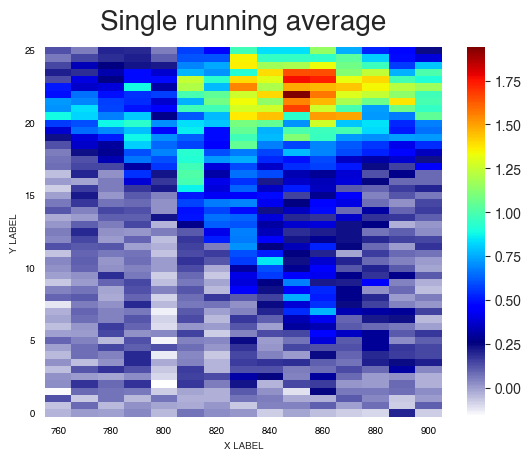

In [68]:
#Greiner map
greiner_data = {'red': ((0., 1, 1,), (.2, 0, 0), (.48, 0, 0), (.728, 1, 1), (0.912, 1, 1), (1, .5, .5)),
                'green': ((0., 1, 1), (.2, 0, 0), (.3, 0, 0), (.5, 1, 1), (.712, 1, 1), (.928, 0, 0), (1, 0, 0)),
                'blue': ((0., 1, 1), (.2, .5, .5), (.288, 1, 1), (.472, 1, 1), (.72, 0, 0), (1, 0, 0))}
                # 'blue': ((0., 1, 1), (0., .8, .8), (0., .6, .6), (0., .4, .4), (0., .2, .2), (0., .0, .0))}

greiner = LinearSegmentedColormap('greiner',greiner_data)

cmap = greiner

spectrum(images_res, "Acc_heat_freq", "FB_12", "response",
         ticknum_x = 2,
         ticknum_y = 10,
         decimal_x = "int",
         decimal_y = "int",
         rescale_x = 1,
         rescale_y = 1e3,
         rotation_x = 0,
         title = "Single running average",
         vmin = None,
         vmax = None,
         cmap = cmap)

In [42]:
def lorentzian(x, a, b, c, d):

    return a * c / (const.pi * ((x-b)**2 + c**2)) + d

In [80]:
def slice(images, index, columns, values, exclude):

    slices = []
    opt = []
    err = []

    heat = images.pivot(index = index, columns = columns, values = values)

    for slice_val in heat.columns:
        if slice_val not in exclude:

            slice = heat[slice_val]

            slices.append(slice)
            popt, pcov = curve_fit(lorentzian, heat.index, slice, p0 = [1, 18, 1, 0.1])

            opt.append(popt)
            err.append(np.sqrt(np.diag(pcov)))

    return slices, np.array(opt), np.array(err)

In [83]:
slices, popt, perr = slice(images_res, index = variables[2], columns = variables[1], values = "response", exclude = [0.7])

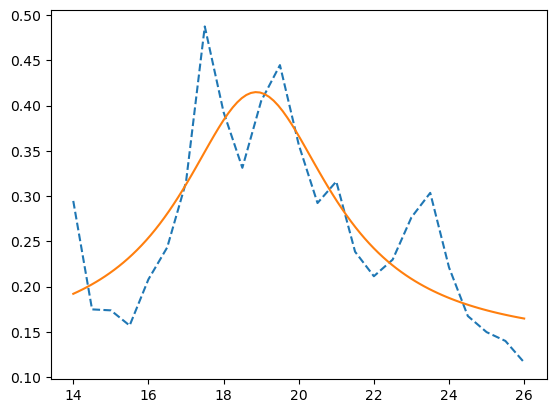

In [87]:
field = 0

x = np.linspace(14, 26, 100)

plt.plot(slices[field], ls = "--")
plt.plot(x, lorentzian(x, *popt[field]))
plt.show()

ValueError: 'x' and 'y' must have the same size

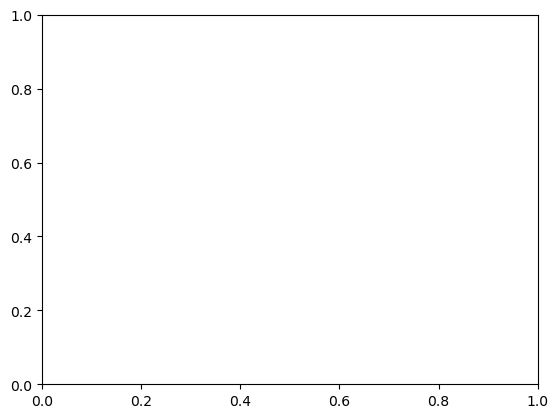

In [85]:
x = var_vals[1].copy()

plt.errorbar(x, popt[:, 1], perr[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)
plt.errorbar()
plt.show()

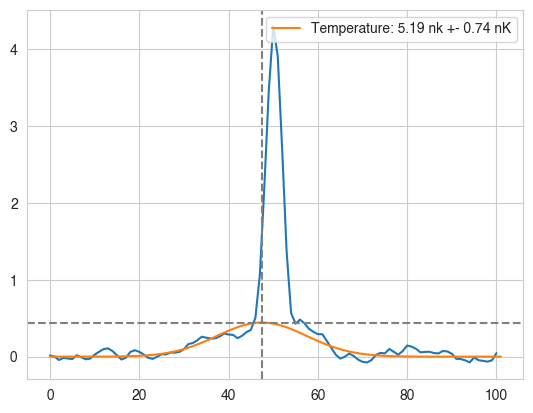

Temperature: 5.19 nk +- 0.74 nK
FB_Img: 720.0 nK
[  0.44445261  47.44448339 202.34921312]



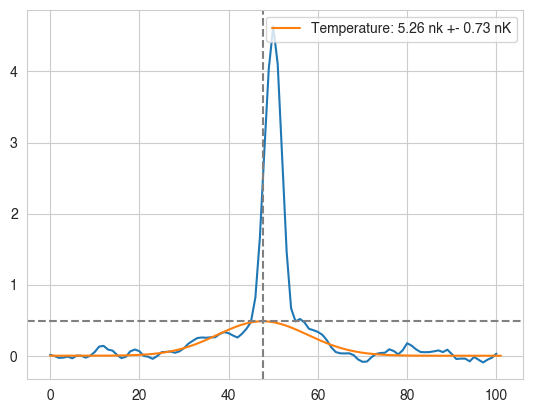

Temperature: 5.26 nk +- 0.73 nK
FB_Img: 750.0 nK
[  0.48481026  47.59900377 205.24321952]



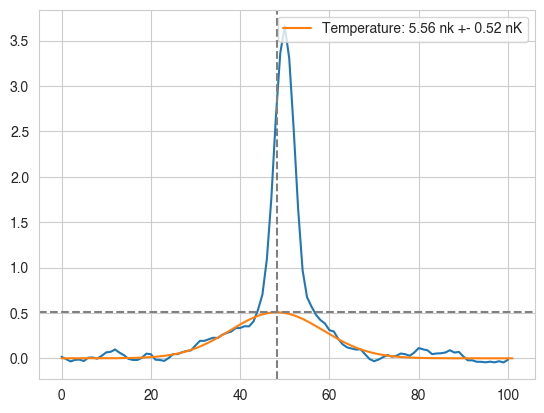

Temperature: 5.56 nk +- 0.52 nK
FB_Img: 780.0 nK
[  0.50712219  48.18774912 216.81736575]



In [28]:
for i, im in images_fit.iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))

    plt.plot(pos, T4)

    plt.plot(np.linspace(0, len(T4), 1000), la.gauss(np.linspace(0, len(T4), 1000), *im["T4_params"]), label = f"Temperature: {im["temperature"][0]:.2f} nk +- {im["temperature"][1]:.2f} nK")

    # plt.plot(la.parab(np.linspace(0, len(T4), len(T4)), im["T4_params"][3],
    #                                                     im["T4_params"][4],
    #                                                     im["T4_params"][5]))

    # plt.plot(np.linspace(0, len(T4), 1000), la.gauss_parab(np.linspace(0, len(T4), 1000), *im["T4_params"]), label = f"Temperature: {im["temperature"][0]:.2f} nk +- {im["temperature"][1]:.2f} nK")

    # plt.axhline(im["T4_params"][0] + im["T4_params"][3], color = "grey", ls = "--")
    plt.axhline(im["T4_peak"], color = "grey", ls = "--")
    plt.axvline(im["T4_params"][1], color = "grey", ls = "--")
    # plt.axvline(im["T4_params"][4], color = "grey", ls = "--")

    plt.legend(loc = 1)

    plt.show()

    # print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK @ {im["FB_Img"]:.0f} G")
    print(f"Temperature: {im["temperature"][0]:.2f} nk +- {im["temperature"][1]:.2f} nK")
    print(f"FB_Img: {im["FB_Img"]} nK")
    print(im["T4_params"])
    print("")

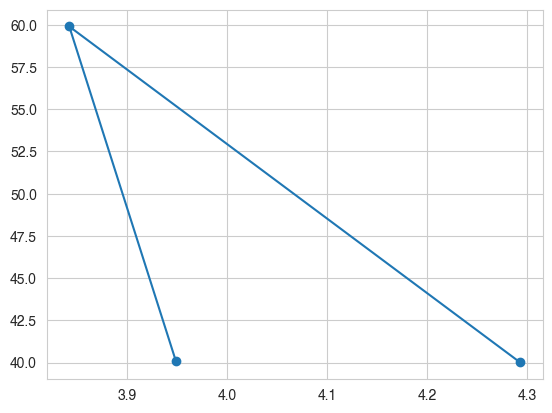

In [24]:
peeeek = []
TTT = []

for i, im in images_fit.iterrows():
    peeeek.append(im["T4_params"][-2])
    TTT.append(im["temperature"][0])

plt.scatter(TTT, peeeek)
plt.plot(TTT, peeeek)

plt.show()


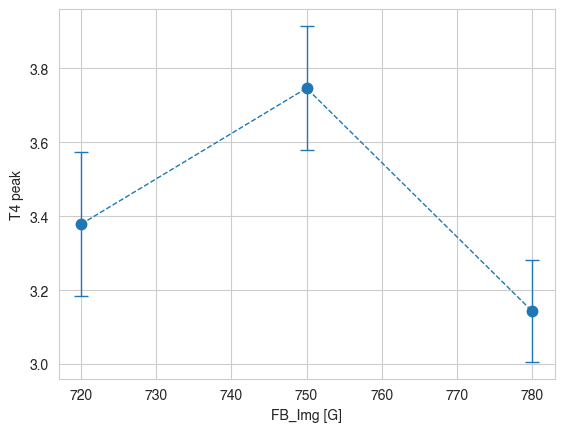

In [25]:
# plt.plot(images_fit["FB_10"], images_fit["T4_run_peak"])
# plt.scatter(images_res["FB_10"], images_res["response"])
plt.errorbar(images_res["FB_Img"], images_res["T4_run_peak"], images_res['T4_run_peak_var'],
             marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.xlabel("FB_Img [G]")
plt.ylabel("T4 peak")

# plt.ylim(0, 4)

plt.show()

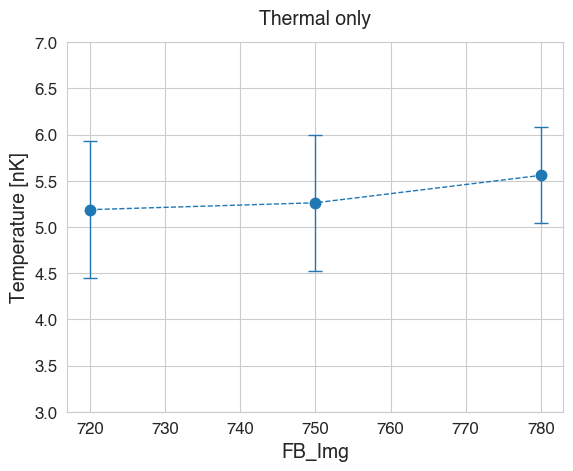

In [30]:
x = np.array(images_fit["FB_Img"].tolist())
y = np.array(images_fit["temperature"].tolist())

plt.errorbar(x, y[:, 0], y[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.title("Thermal only", fontsize = 14, pad = 13)
plt.xlabel(f"{variables[1]}", fontsize = 14)
plt.ylabel("Temperature [nK]", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.ylim(3, 7)

plt.grid(visible = True, which = "both")

plt.show()